# Feedback Control of a non-Markovian single qubit system

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from qutip.cy.spmatfuncs import (cy_expect_rho_vec, spmv)
import numpy as np
import math
from qutip import *

### Implementation in QuTiP

The original stochastic master equation on the form:

$$ d\rho_c(t) = -i[H(t), \rho_c(t)] dt + \frac{\gamma}{2}\mathcal{D}[\sigma]\rho_c(t) dt + \mathcal{D}[c]\rho_c(t) dt + \mathcal{H}[c]\rho_c(t) dW,$$

where $c = \sqrt{2k}\sigma_m$ is the dissipation operator associated with the observable. And,

$$\mathcal{D}[c]\rho = c \rho c^\dagger - \frac{1}{2}(c^\dagger c \rho + \rho c^\dagger c)$$

$$\mathcal{H}[c]\rho = c \rho  + \rho c^\dagger - \langle c + c^\dagger \rangle \rho$$

This equation can be implemented by $D_1$ and $D_2$ callback functions in stochastic master equation.

In this paper, we will replace the thermal noise $\frac{\gamma}{2}\mathcal{D}[\sigma]\rho_c(t) dt$ by non-Markovian noise (by using an ancilla cavity)

# The control model

Control Hamiltonian:
$$H(t) =  sgn[\theta(t)](\omega/2)\sigma_y$$
where
$$\theta = arctan(a_x/a_z)$$
Measurement operator:
$$\sigma_m = sin(\alpha) \sigma_x - cos(\alpha) \sigma_z $$
where
$$\alpha = c_0 + c_1\theta(t)$$

$$c_0 = \begin{cases}
0 & \omega < 45k \\    \pi/2 & \omega > 45k
\end{cases}$$

$$c_1 = -A -B\left[ 1- e^{-r\omega/k}\right]$$
A and B are control parameters given by Table 1

# Case 1: $\omega = 20k$

In [33]:
# Parameters
k = 1.0 # normalization
gamma = 0.1 # ancilla cavity dissipation
kappa = 1.0 # system - ancilla cavity coupling strength

# number of levels in ancilla cavity
Nanc = 20 
# Simulation time
tlist = np.linspace(0,0.1,1001)

# qubit Pauli operators
sm1 = tensor(sigmam(), qeye(Nanc))
sz1 = tensor(sigmaz(), qeye(Nanc))
sy1 = tensor(sigmay(), qeye(Nanc))
sx1 = tensor(sigmax(), qeye(Nanc))
si1 = tensor(qeye(2), qeye(Nanc))
# Ancillary cavity operator
a1 = tensor(qeye(2), destroy(Nanc))

# Interaction Hamiltonian
c = -(np.sqrt(gamma)/2.0)*a1
z = np.sqrt(kappa)*sm1

Hi = 1j*(c.dag()*z - z.dag()*c)


# Total Hamiltonian
H = Hi

# Initial measurement operator
theta0 = 0.5*math.pi
c0 = 0.0
A = 0.5
B = 0.186
r = 0.476
omega = 20*k
c1 = -A -B*(1 - math.exp(-r*omega/k))
alpha = c0 + c1*theta0
sigmaM = np.sin(alpha)*sx1 - np.cos(alpha)*sz1
c = np.sqrt(2.0*k)*sigmaM

# Noise

#L_th = np.sqrt(gamma)*sm1
L_th = np.sqrt(gamma)*a1

# Measurement channel
L_m = c

# Expectation Bloch operators
Ex = sx1
Ey = sy1
Ez = sz1

# No deterministic dissipation
c_ops = [L_th]

# Stochastic (monitored channel)
sc_ops = [L_m] #just add a dumpy one, we do not use it

# intial state: random state
psi0 = tensor(0.5*(0.5*sigmax() + qeye(2)), ket2dm(basis(Nanc, 0)))

# (A) superoperator definition 
#     A[0] = spre(a) = A_L : Multiply on the left
#     A[1] = spost(a) = A_R : Multiply on the right
#     A[2] = spre(a.dag()) = Ad_L : Adjoint and Multiply on the left
#     A[3] = spost(a.dag()) = Ad_R: Adjoint and Multiply on the right
#     A[4] = spre(a.dag() * a) = (Ad A)_L: Multiply on the left by L^\dagger L
#     A[5] = spost(a.dag() * a) = (Ad A)_R: Multiply on the right by L^\dagger L
#     A[6] = (spre(a) * spost(a.dag()) = A_L * Ad_R: Multiply on the left by L and multiply on the right by L^\dagger
#     A[7] = lindblad_dissipator(a): Full Lindblad operator: L * rho * L.dag() - 0.5 * L.dag()*L*rho - 0.5 * rho * L.dag()*L

# Feedback Calculation

# D1 and D2 definitions for stochastic homodyne detection
# D1: Deterministic part with feedback Hamiltonia
def d1_rho_func(t, rho_vec, A, args): 
    # Expected values (filtered) of Bloch vector components
    xH = cy_expect_rho_vec(spre(sx1).data, rho_vec, 1)
    yH = cy_expect_rho_vec(spre(sy1).data, rho_vec, 1)
    zH = cy_expect_rho_vec(spre(sz1).data, rho_vec, 1)
    # Compute the angle
    thetaH = math.atan(xH/(zH-1e-12)) #add a small number to prevent division by 0 
    # Compute the feedback Hamiltonian
    H_fb = -np.sign(thetaH)*(omega/2)*sy1
    # Compute the measurement operator
    alpha_fb = c0 + c1*thetaH
    sigmaM_fb = np.sin(alpha_fb)*sx1 - np.cos(alpha_fb)*sz1
    op_t = liouvillian(H_fb, [np.sqrt(2.0*k)*sigmaM_fb]).data
    return spmv(op_t, rho_vec)

# D2: Stochastic part
def d2_rho_func(t, rho_vec, A, args):
    xH = cy_expect_rho_vec(spre(sx1).data, rho_vec, 1)
    yH = cy_expect_rho_vec(spre(sy1).data, rho_vec, 1)
    zH = cy_expect_rho_vec(spre(sz1).data, rho_vec, 1)
    thetaH = math.atan(xH/(zH-1e-12))
    alpha_fb = c0 + c1*thetaH
    sigmaM_fb = np.sin(alpha_fb)*sx1 - np.cos(alpha_fb)*sz1
    c_fb = np.sqrt(2.0*k)*sigmaM_fb
    n_sum = spre(c_fb).data + spost(c_fb.dag()).data
    e1 = cy_expect_rho_vec(n_sum, rho_vec, False)
    return [n_sum * rho_vec - e1 * rho_vec]



e_ops = [Ex, Ey, Ez]
m_ops = [[Ex]]
ntraj = 1 
nsubsteps = 10


#fresh run, new noise generated
result = smesolve(H, psi0, tlist, c_ops, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps,d1=d1_rho_func,
                  d2=d2_rho_func, distribution='normal', m_ops=m_ops, dW_factors=[1.0],
                  store_measurement=False)

#fixing the noise, using the noise from previous run
#result = smesolve(H, psi0, tlist, c_ops, sc_ops, e_ops, ntraj=ntraj, nsubsteps=nsubsteps,d1=d1_rho_func, d2=d2_rho_func, distribution='normal', m_ops=m_ops, dW_factors=[sqrt(1/kappa)],store_measurement=True, noise=result.noise)

Total run time:  26.29s


# Bloch vector components

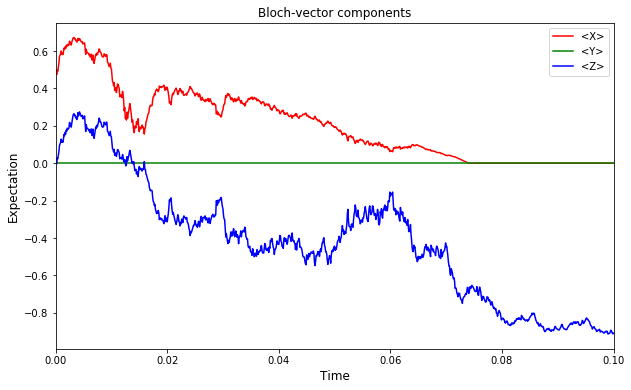

In [34]:
#Plotting the results 
fig, axes = plt.subplots(1,1, figsize=(10,6))

# Plot 1: expectation Bloch vector
n_1 = result.expect[0]
n_2 = result.expect[1]
n_3 = result.expect[2]
thetaR = np.zeros(n_1.size)
for i in range(0, n_1.size):
    thetaR[i] = math.atan(n_1[i]/(n_3[i] + 1.0e-12))/(math.pi)
axes.plot(tlist, n_1,'r',label="<X>")
axes.plot(tlist, n_2,'g',label="<Y>")
axes.plot(tlist, n_3,'b',label="<Z>")
axes.legend(loc=0)
axes.set_xlim([tlist[0], tlist[tlist.size - 1]])
axes.set_xlabel('Time', fontsize=12)
axes.set_ylabel('Expectation', fontsize=12)
axes.set_title('Bloch-vector components', fontsize=12)

# First Plot: Theta

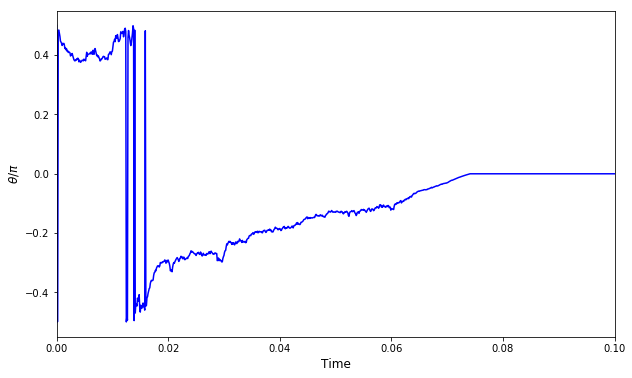

In [35]:
#Plotting the results 
fig, axes = plt.subplots(1,1, figsize=(10,6))
axes.plot(tlist, thetaR,'b')
axes.set_xlim([tlist[0], tlist[tlist.size - 1]])
axes.set_xlabel('Time', fontsize=12)
axes.set_ylabel(r'$\theta/\pi$', fontsize=12)

# Second Plot: 1 - |a|

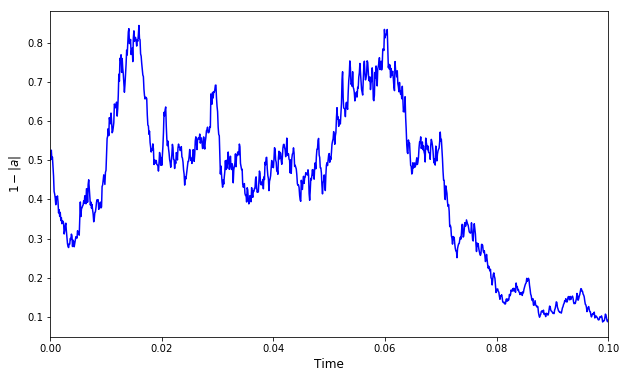

In [36]:
#Plotting the results 
fig, axes = plt.subplots(1,1, figsize=(10,6))

val = np.zeros(n_1.size)
for i in range(0, n_1.size):
    val[i] = 1 - np.sqrt(n_1[i]*n_1[i] + n_2[i]*n_2[i] + n_3[i]*n_3[i])
axes.plot(tlist, val,'b')
axes.set_xlim([tlist[0], tlist[tlist.size - 1]])
axes.set_xlabel('Time', fontsize=12)
axes.set_ylabel(r'$1 - |a|$', fontsize=12)